In [1]:
from pathlib import Path
import datetime
import pandas as pd
import xarray as xr
import rioxarray as rioxr
import dask
import zarr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
districtsToExtract = ['Sylhet'] # Either an array of districts (can also just be one), or 'All'

In [3]:
timeRange = ['2021-01-01', '2021-12-31'] # Either a time start and stop, or 'All'

In [4]:
datapath = Path('Data/BangladeshTimeSeriesZarr/')

In [5]:
dataset = xr.open_zarr(datapath)

In [6]:
dataset['time'] = pd.DatetimeIndex(dataset['time'].values)

In [7]:
if timeRange != 'All':
    index = (dataset.time.values >= pd.to_datetime(timeRange[0], format='%Y-%m-%d'))\
    & (dataset.time.values <= pd.to_datetime(timeRange[1], format='%Y-%m-%d'))
    dataset = dataset.sel(time=index)

In [8]:
shapefilepath = Path('Data/ShapeFiles/bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm2_bbs_20201113.shp')

In [9]:
districts = gpd.read_file(shapefilepath)

In [10]:
if districtsToExtract != 'All':
    districts = districts.iloc[[name in districtsToExtract for name in districts.ADM2_EN.values],:]

In [11]:
crs = districts.crs

In [12]:
districts = districts.set_crs(crs)

In [13]:
dataset = dataset.rio.set_crs(crs)

In [14]:
dataset = dataset.rio.write_crs()

In [15]:
dataset = dataset.rio.clip(districts.geometry.values, districts.crs, drop=True, invert=False, all_touched=True)

In [16]:
dataset = dataset.sortby('time')

In [17]:
quantinundation = dataset.quantile([.025, .25,.5,.75, .975], dim=['x','y'], skipna=True)#.squeeze().to_array().sortby('time')

In [18]:
q50 = quantinundation.sel(quantile=.5).squeeze().to_array().sortby('time').values.squeeze()
q75 = quantinundation.sel(quantile=.75).squeeze().to_array().sortby('time').values.squeeze()
q25 = quantinundation.sel(quantile=.25).squeeze().to_array().sortby('time').values.squeeze()
q025 = quantinundation.sel(quantile=.025).squeeze().to_array().sortby('time').values.squeeze()
q975 = quantinundation.sel(quantile=.975).squeeze().to_array().sortby('time').values.squeeze()
time = quantinundation.sortby('time').time.values

In [19]:
timeSeriesGifPath = Path('TimeSeriesGif')
timeSeriesGifPath.mkdir(parents=True, exist_ok=True)

In [20]:
maxBinValue = 0
for index in range(len(time)):
    dataForData = dataset.isel(time=index).to_array().squeeze()
    newMaxBinValue = np.max(np.histogram(dataForData.values.flatten(), np.linspace(0,1,100))[0])
    maxBinValue = np.max([maxBinValue, newMaxBinValue])

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# you can change the location of the legend:
# 'upper right'  : 1,
# 'upper left'   : 2,
# 'lower left'   : 3,
# 'lower right'  : 4,
# 'right'        : 5,
# 'center left'  : 6,
# 'center right' : 7,
# 'lower center' : 8,
# 'upper center' : 9,
# 'center'       : 10
loc = 4

# add more or less padding:
borderpad = 6

dpi=60
fontsize=16

In [22]:
def PlotData(dataForData, fig, time_i):
    height = 4
    spec = fig.add_gridspec(height, 1)

    ax = fig.add_subplot(spec[0:(height-2), 0])
    
    ######################
    
    im = dataForData.plot.imshow(interpolation='none', vmin=0, vmax=1, add_colorbar=False, cmap='Blues', ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title('')
    ax.set_facecolor([.9,.9,.9])

    ax.text(.75,.95,pd.to_datetime(time_i).strftime('%b %d %Y'), fontsize=20, transform=ax.transAxes)

    cax = inset_axes(ax, width=.2, height=2, loc=loc, borderpad=borderpad)
    fig.colorbar(im, cax=cax)
    cax.tick_params(labelsize=fontsize)
    cax.set_ylabel('Fractional Inundated Area', fontsize=12)

    ######################
    ax = fig.add_subplot(spec[(height-2), 0])

    ax.hist(dataForData.values.flatten(), np.linspace(0,1,100), facecolor='b', alpha=.6)
    ax.set_xlim([0,1])
    ax.set_ylim([0,maxBinValue * 1.1])

    ax.set_xlabel('Fractional Inundated Area', fontsize=fontsize)
    ax.set_ylabel('# pixels', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

    ######################
    ax = fig.add_subplot(spec[(height-1), 0])

    ax.fill_between(time, q25, q75, facecolor='b', alpha=.2, label='Q25-Q75')
    ax.plot(time, q50, 'b', label='Median')
    ax.axvline(time_i,color='r')
    ax.set_xlabel('Year', fontsize=fontsize)
    ax.set_ylabel('Fractional Inundated Area', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.legend()

In [23]:
maxBinValue

2420

/Users/jgiezendanner/mambaforge/envs/deeplearning/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/jgiezendanner/mambaforge/envs/deeplearning/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


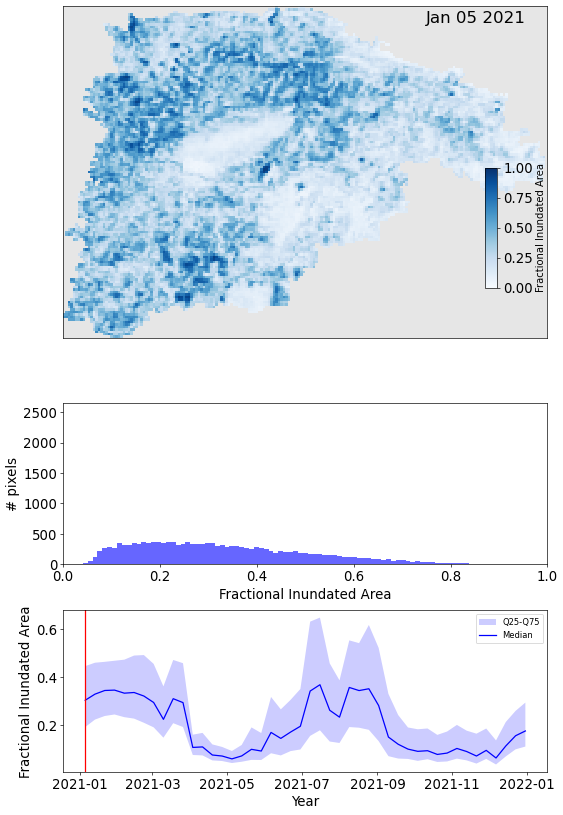

In [24]:
# plot figure once to see if everything is okay
dataForData = dataset.isel(time=0).to_array().squeeze()
fig = plt.figure(figsize=(9.5, 14), layout="tight", dpi=dpi)

PlotData(dataForData, fig, time[0])

In [25]:
for index in range(len(time)):
    time_i = time[index]
    dataForData = dataset.isel(time=index).to_array().squeeze()
    fig = plt.figure(figsize=(9.5, 14), layout="tight", dpi=dpi)

    PlotData(dataForData, fig, time_i)

    fig.savefig(f'TimeSeriesGif/{index}.png', bbox_inches='tight')

    plt.close()